In [58]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
from orographicPrecipitation.precip_model_functions import qsat
from scipy.ndimage import gaussian_filter


# Functions

In [2]:
ERA5M_PATH  = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"
ERA5M_PATH2 = "/global/project/projectdirs/m3310/wboos/era5monthly/"

boxNH = [[-100, -70, 12 , 20],
         [-80 , -60, 8  , 16],
         [70  , 90 , 2  , 18],
         [100 , 120, 8  , 20],
         [118 , 140, 4  , 20],
         [100 , 110, 0  , 12],
        ]

boxSH = [[20  , 50 , -20, 0 ],
         [-60 , -30, -20, 0 ],
        ]

boxNH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxNH]
boxSH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxSH]

namesNH = ["Central America",
           "Venezuela",
           "South India / Sri Lanka",
           "Vietnam / South China Sea",
           "Philippines",
           "Malaysia"
          ]
namesSH = ["Tanzania",
           "NorthEast Brazil"
          ]

In [12]:
#Data extraction from ERA5
era5yrs = list(range(1979,2019))

def retrieve_era5(year,varid):
    """gather an ERA5 monthly mean variable for the year 'year'
    varid gives the id of the variable in era5
        - year : str, "YYYY"
        - varid : str, eg. "128_130_t" for temperature
    """
    era5var = xr.open_dataset(glob.glob(os.path.join(ERA5M_PATH,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0])
    varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'T' for temperature
    
    return era5var[varname]

def retrieve_era5_month(month,varid):
    varlist = []
    for year in era5yrs:
        var = retrieve_era5(year,varid)
        varmonth = var.sel(time="%s-%s"%(year,month))
        varlist.append(varmonth)
    return xr.concat(varlist, "time")

#climatological mean computation
def climat_mean(month,varid):
    """Compute the climatological mean of a variable specified by 'varid', for a specific month
        - month : str, eg. '05' for May
        - varid : str, eg. "128_130_t" for temperature
    """    
    vartot=0
    for year in era5yrs:
        var = retrieve_era5(year,varid)
        varmonth = var.sel(time="%s-%s"%(year,month)).isel(time=0)
        vartot+=varmonth
    return vartot/len(era5yrs)

def climat_mean_700hpa(month,varid):
    vartot=0
    for year in era5yrs:
        var = retrieve_era5(year,varid)
        varmonth = var.sel(time="%s-%s"%(year,month),level=700.).isel(time=0)
        vartot+=varmonth
    return vartot/len(era5yrs)


def region_mean2D(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    mask_box = mask.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    variable_box = variable.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    
    return region_mean


# Masks, data

In [4]:
def slide_coord(mask):
    """Switch the longitude coord from (-180,180) to (0,360) 
    and change coordinate names from 'LAT1','LON1' to 'latitude' and 'longitude'"""
    mask0=mask.copy()
    mask0.coords['longitude'] = mask0.coords['LON1']%360
    mask1 = mask0.swap_dims({'LON1': 'longitude'}).rename({'LAT1': 'latitude'})

    #Sort the longitude values
    sort_inds = {"longitude": np.argsort(mask1["longitude"].values)}
    mask1 = mask1.isel(**sort_inds)
    return mask1

#masks = xr.open_dataset("/global/cscratch1/sd/qnicolas/masks/winter_rainfall_masks.nc")
#/!\ temporary change for access on Spin
masks = xr.open_dataset("winter_rainfall_masks.nc")
trmm_nh_winter_mask = masks.TRMM_NH_WINTER_MASK.fillna(0.)
trmm_sh_winter_mask = masks.TRMM_SH_WINTER_MASK.fillna(0.)


## To be modified
REFERENCE_GRID = xr.open_dataset(ERA5M_PATH+"e5.moda.an.pl/e5.moda.an.pl.128_060_pv.ll025sc.1979010100_1979120100.nc").PV.sel(latitude=slice(50., -50.)).isel(time=0) #to get the era5 grid

trmm_nh_winter_mask1 = (slide_coord(trmm_nh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_sh_winter_mask1 = (slide_coord(trmm_sh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_nh_winter_mask2 = slide_coord(trmm_nh_winter_mask)
trmm_sh_winter_mask2 = slide_coord(trmm_sh_winter_mask)                     

In [5]:
CMIP6_FOLDER="/global/cfs/projectdirs/m3522/cmip6/"

landmask = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
landmask50=landmask.interp_like(REFERENCE_GRID)


In [64]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

ddxorog = xr.apply_ufunc(gaussian_filter,ddxorog,kwargs={"sigma":2.})
ddyorog = xr.apply_ufunc(gaussian_filter,ddyorog,kwargs={"sigma":2.})

In [11]:
pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_mnthmean = pr_trmm_all.groupby("time.month").mean("time")
pr_trmm_nov = pr_trmm_mnthmean.sel(month=11)
pr_trmm_may = pr_trmm_mnthmean.sel(month=5)

# Vertical motions

In [7]:
t=time.time()
all_ww_nov = retrieve_era5_month("11",'128_135_w');all_ww_may = retrieve_era5_month("05",'128_135_w')
print(time.time()-t)

169.16024565696716


In [8]:
t=time.time()
mean_ww_nov = all_ww_nov.mean('time'); mean_ww_may = all_ww_may.mean('time')
print(time.time()-t)

32.353962659835815


In [9]:
t=time.time()
mean_100u_nov = climat_mean("11","228_246_100u"); mean_100u_may = climat_mean("05","228_246_100u")
mean_100v_nov = climat_mean("11","228_247_100v"); mean_100v_may = climat_mean("05","228_247_100v")
print(time.time()-t)

40.57651162147522


In [14]:
t=time.time()
mean_u700hpa_nov = climat_mean_700hpa("11","128_131_u"); mean_u700hpa_may = climat_mean_700hpa("05","128_131_u")
mean_v700hpa_nov = climat_mean_700hpa("11","128_132_v"); mean_v700hpa_may = climat_mean_700hpa("05","128_132_v")
print(time.time()-t)

184.1922972202301


In [65]:
mean_wupslope_nov = -10.*(mean_100u_nov*ddxorog + mean_100v_nov*ddyorog) #(omega = -rho*g*w)
mean_wupslope_may = -10.*(mean_100u_may*ddxorog + mean_100v_may*ddyorog)
mean_wupslope700_nov = -10.*(mean_u700hpa_nov*ddxorog + mean_v700hpa_nov*ddyorog)
mean_wupslope700_may = -10.*(mean_u700hpa_may*ddxorog + mean_v700hpa_may*ddyorog)

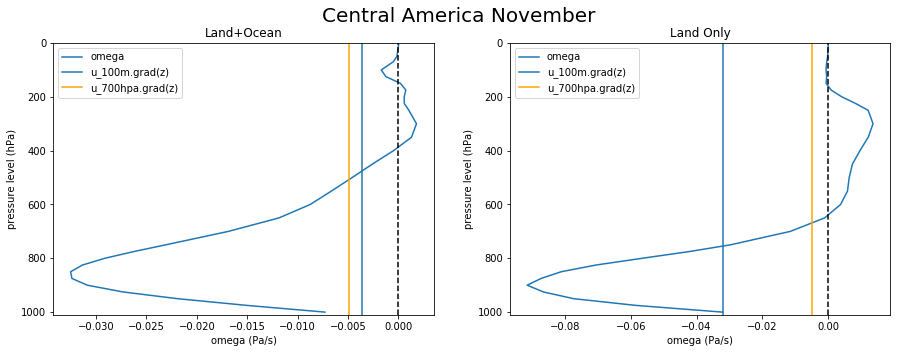

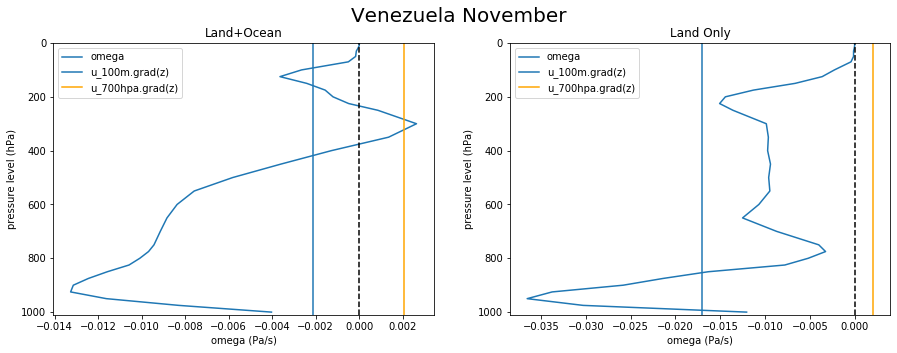

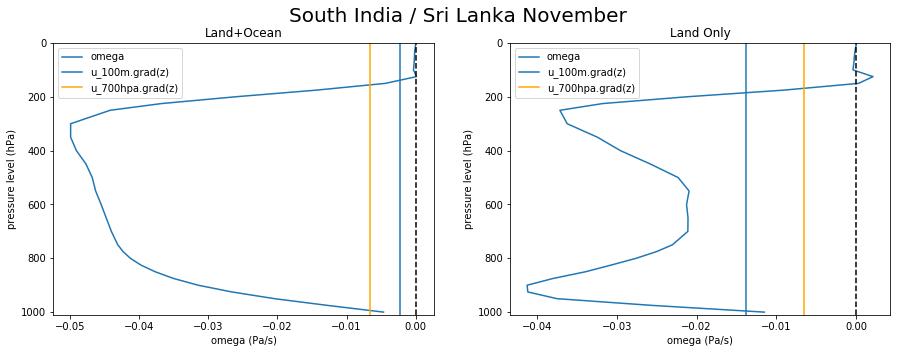

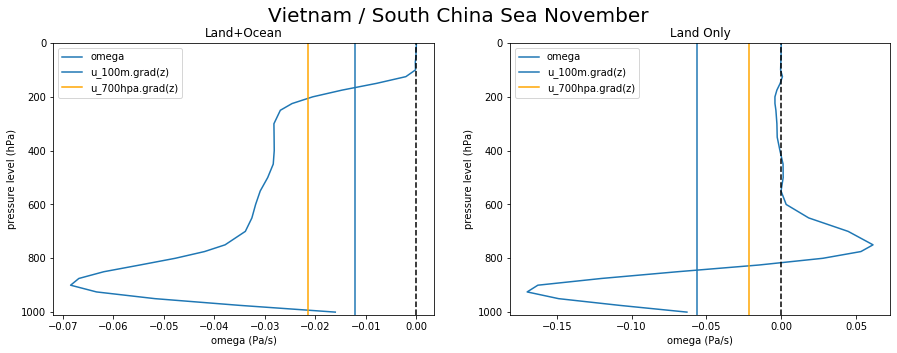

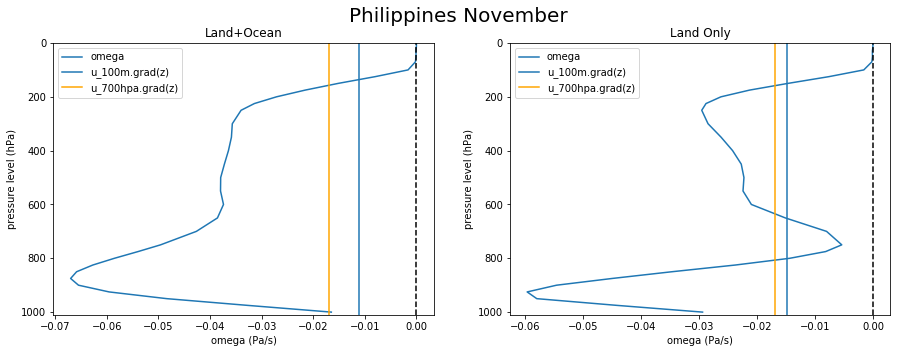

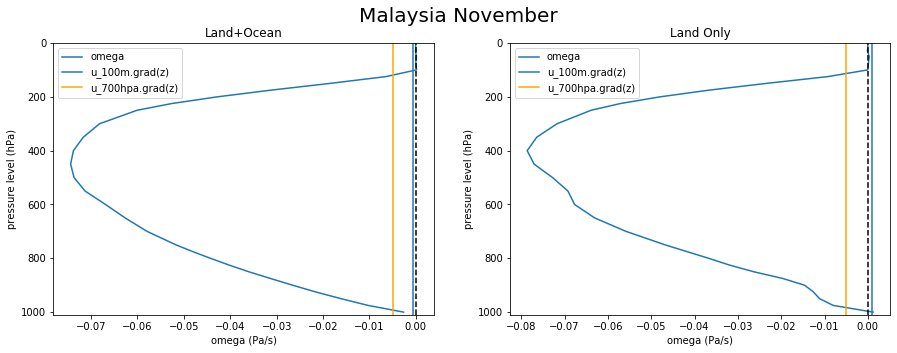

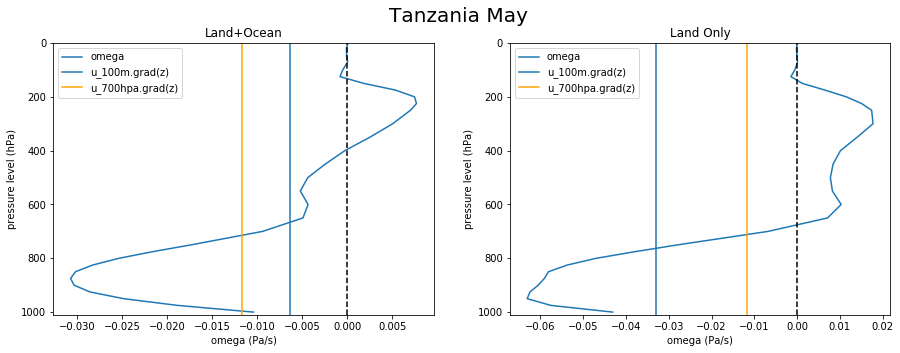

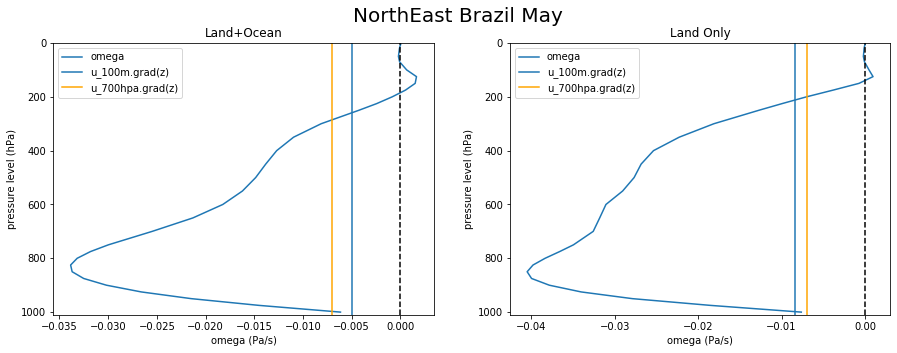

In [66]:
def plot_vmotions(boxes,maskk,maskkl,w1,w2,w3,month,names):
    for i,box in enumerate(boxes):
        #Mean state values
        w1_box = region_mean2D(w1,maskk,box)
        w2_box = region_mean2D(w2,maskk,box)
        w3_box = region_mean2D(w3,maskk,box)
        
        w1_box_land = region_mean2D(w1,maskkl,box)
        w2_box_land = region_mean2D(w2,maskkl,box)
        w3_box_land = region_mean2D(w3,maskkl,box)
        
        fig = plt.figure(figsize=(15,5))
        ax1 = fig.add_subplot(121)
        ax1.plot(w1_box,w1_box.level ,label="omega")
        ax1.axvline(w2_box,label="u_100m.grad(z)")
        ax1.axvline(w3_box,label="u_700hpa.grad(z)",color='orange')
        ax1.axvline(0,linestyle='--',color="k")
        ax1.set_xlabel("omega (Pa/s)")
        ax1.set_ylabel("pressure level (hPa)")
        ax1.set_ylim(1010, 0)
        ax1.legend(loc='upper left')
        ax1.set_title('Land+Ocean')

        ax2 = fig.add_subplot(122)
        ax2.plot(w1_box_land,w1_box_land.level ,label="omega")
        ax2.axvline(w2_box_land,label="u_100m.grad(z)")
        ax2.axvline(w3_box,label="u_700hpa.grad(z)",color='orange')
        ax2.axvline(0,linestyle='--',color="k")
        ax2.set_xlabel("omega (Pa/s)")
        ax2.set_ylabel("pressure level (hPa)")
        ax2.set_ylim(1010, 0)
        ax2.legend(loc='upper left')  
        ax2.set_title('Land Only')

        fig.suptitle(names[i]+" %s"%month,fontsize=20)

plot_vmotions(boxNH1,trmm_nh_winter_mask1,trmm_nh_winter_mask1*landmask50,mean_ww_nov,mean_wupslope_nov,mean_wupslope700_nov,"November",namesNH)
plot_vmotions(boxSH1,trmm_sh_winter_mask1,trmm_sh_winter_mask1*landmask50,mean_ww_may,mean_wupslope_may,mean_wupslope700_may,"May",namesSH)

        

# 2d maps of precip vs Roe model

In [20]:
t=time.time()
mean_2t_nov = climat_mean("11","128_167_2t"); mean_2t_may = climat_mean("05","128_167_2t")
mean_sp_nov = climat_mean("11","128_134_sp"); mean_sp_may = climat_mean("05","128_134_sp")
print(time.time()-t)

38.36206364631653


In [67]:
pr_roe_nov = np.maximum(-86400*qsat(mean_2t_nov,mean_sp_nov/100.)*mean_wupslope_nov/9.81,0.)
pr_roe_may = np.maximum(-86400*qsat(mean_2t_may,mean_sp_may/100.)*mean_wupslope_may/9.81,0.)


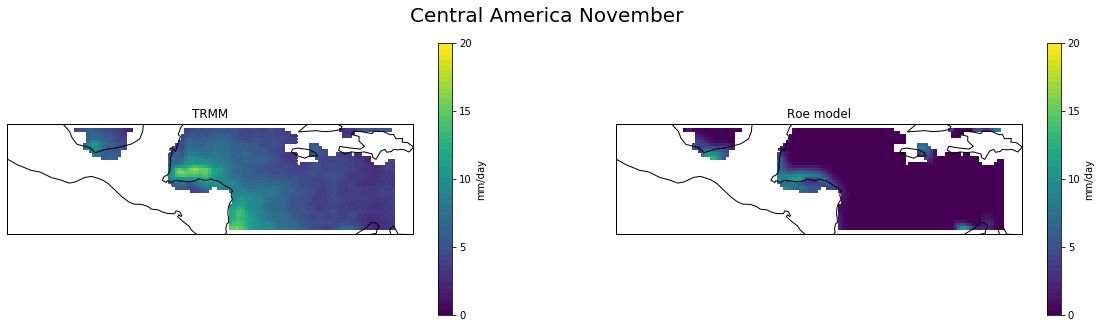

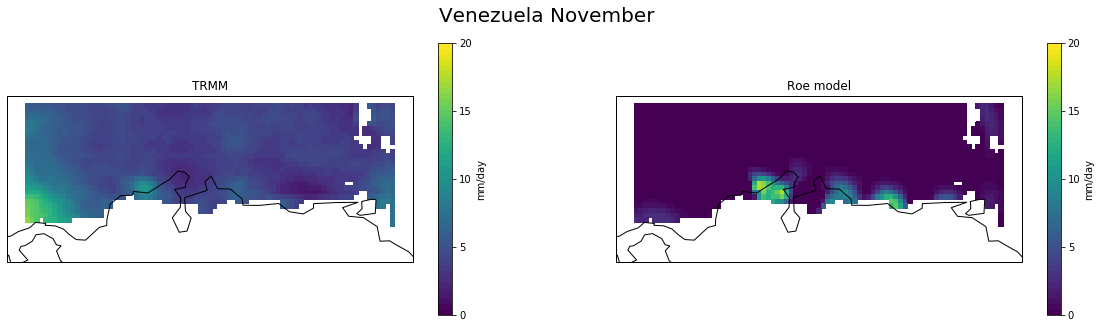

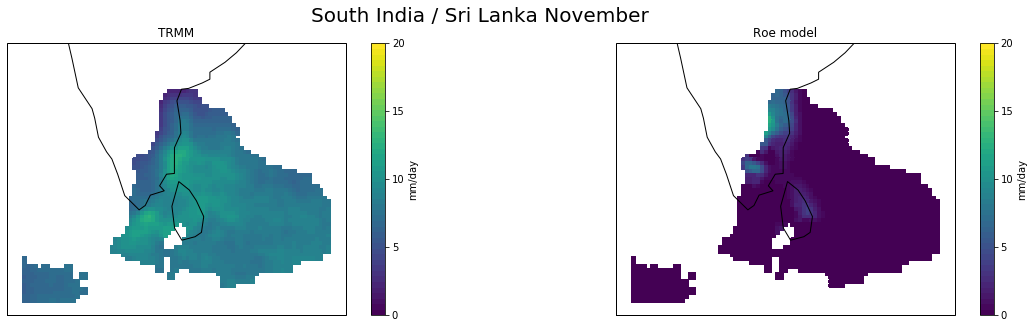

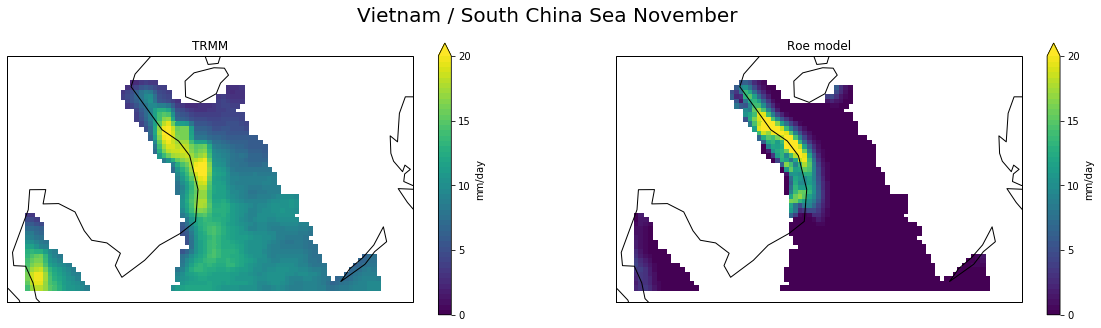

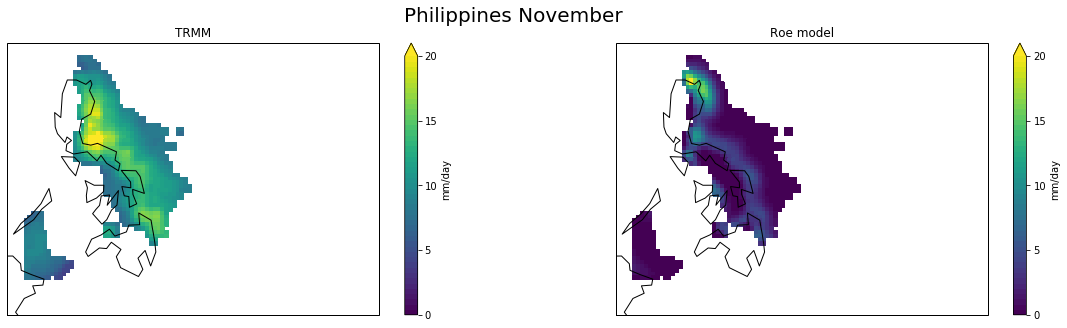

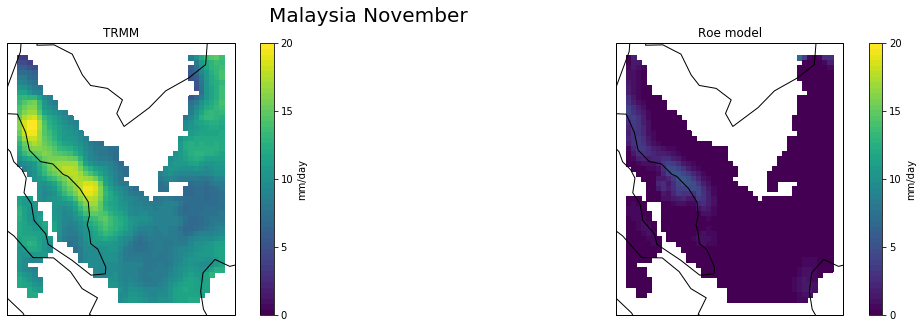

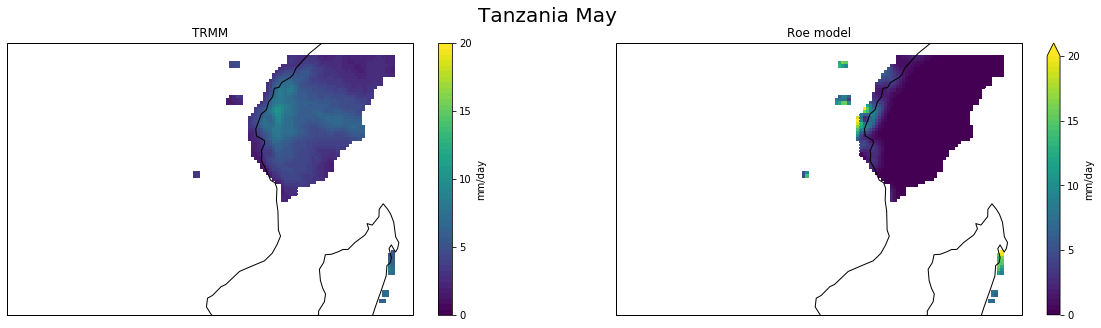

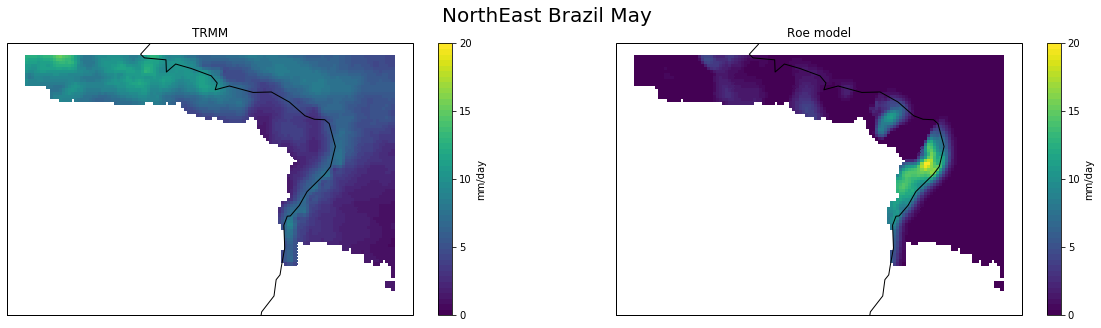

In [69]:
def plot_precips(boxes,maskk,pr1,pr2,month,names):
    for i,box in enumerate(boxes):
        mask = maskk.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        
        pr1_box = pr1.interp_like(mask).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2])) 
        pr2_box = pr2.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))   
        
        pr1_box = pr1_box.where(mask==1)
        pr2_box = pr2_box.where(mask==1)
        
        M = 20.
        fig, ax = plt.subplots(1,2,figsize=(20,5),subplot_kw={'projection': ccrs.PlateCarree()})
        pr1_box.plot(ax=ax[0],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":np.arange(0,M+1,M/4)},levels=np.linspace(0,M,50))
        pr2_box.plot(ax=ax[1],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":np.arange(0,M+1,M/4)},levels=np.linspace(0,M,50))
        ax[0].set_title("TRMM")
        ax[1].set_title("Roe model")
        ax[0].coastlines()
        ax[1].coastlines()
        
        fig.suptitle(names[i]+" %s"%month,fontsize=20)
        
        #trmmmask = cartopy.feature.ShapelyFeature(mask,ccrs.PlateCarree())
        #ax[0].add_feature(trmmmask, zorder=100, edgecolor='k')
        
plot_precips(boxNH1,trmm_nh_winter_mask1,pr_trmm_nov,pr_roe_nov,"November",namesNH)
plot_precips(boxSH1,trmm_sh_winter_mask1,pr_trmm_may,pr_roe_may,"May",namesSH)
